In [1]:
import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat
import auxiliary_functions

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.image as mpimg

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [2]:
selected_lamdas = np.logspace(-5,0,10)

In [3]:
net_heat0 = ContTempNetwork.load('evolving_SBM_net0')
net_heat1 = ContTempNetwork.load('evolving_SBM_net1')
net_heat2 = ContTempNetwork.load('evolving_SBM_net2')
net_heat3 = ContTempNetwork.load('evolving_SBM_net3')

In [4]:
# Example matrices for demonstration
matrix1_0 = net_heat0.compute_static_adjacency_matrix(start_time=0, end_time=150).toarray()
matrix2_0 = net_heat0.compute_static_adjacency_matrix(start_time=150, end_time=300).toarray()

# Example matrices for demonstration
matrix1_1 = net_heat1.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2_1 = net_heat1.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3_1 = net_heat1.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

# Example matrices for demonstration
matrix1_2 = net_heat2.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2_2 = net_heat2.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3_2 = net_heat2.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

# Example matrices for demonstration
matrix1_3 = net_heat3.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray()
matrix2_3 = net_heat3.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray()
matrix3_3 = net_heat3.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray()

# Define the time intervals for the x-axis
time_intervals_0 = [(0, 150), (150, 300)]
# Define the time intervals for the x-axis
time_intervals_123 = [(0, 100), (100, 200),  (200, 300)]


In [5]:
Conditional_S_selected0 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net0/S_rate/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected0.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected_back0 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net0/S_rate_back/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_back0.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected1 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net1/S_rate/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected1.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected_back1 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net1/S_rate_back/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_back1.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected2 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net2/S_rate/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected2.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected_back2 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net2/S_rate_back/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_back2.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected3 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net3/S_rate/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected3.append(S_rate['S_rate'][f'{lamda:.11f}'])

Conditional_S_selected_back3 = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/evolving_SBM_heat/net3/S_rate_back/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected_back3.append(S_rate['S_rate'][f'{lamda:.11f}'])

/tmp/ipykernel_193482/3895669316.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


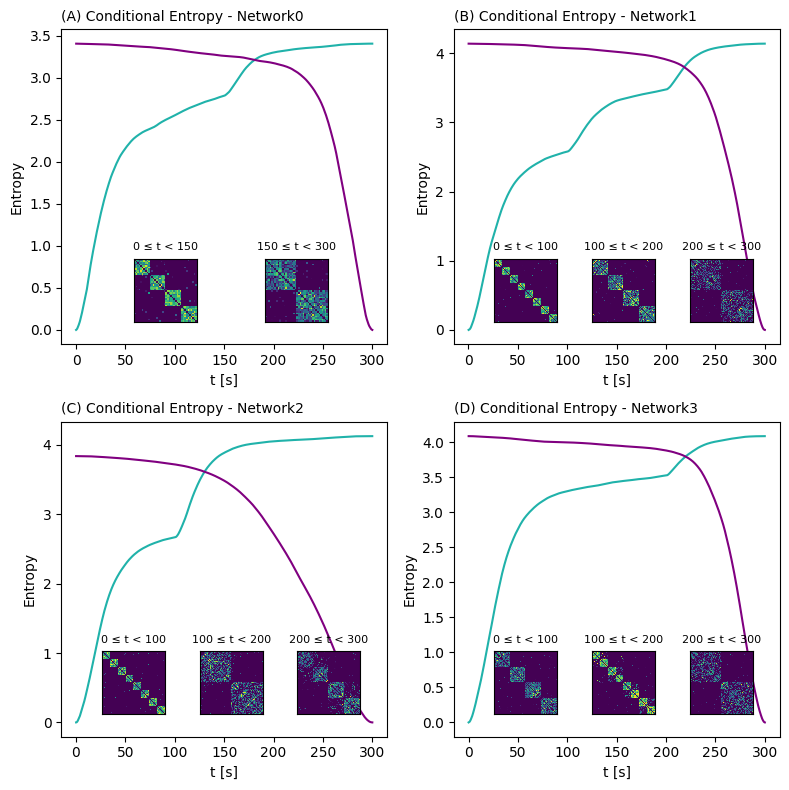

In [6]:
# Start creating the figure
fig = plt.figure(figsize=(8, 8))  # Wider figure for all plots in one row
gs = fig.add_gridspec(2, 2)  # Grid: 1 row, 4 columns

# Column 1: Plot A
ax_a = fig.add_subplot(gs[0, 0])
color_forw = 'lightseagreen'
color_back = 'purple'

index = 5
S = Conditional_S_selected0[index]
S_back = Conditional_S_selected_back0[index]

ax_a.plot(net_heat0.times[:-1], S, color=color_forw, alpha=1)
ax_a.plot(list(net_heat0.times)[:0:-1], S_back, color=color_back, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(A) Conditional Entropy - Network0", loc='left', fontsize=10)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1_0, matrix2_0]
positions = [0.20, 0.60]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals_0[i][0]} ≤ t < {time_intervals_0[i][1]}", fontsize=8)


# Column 2: Plot B
ax_a = fig.add_subplot(gs[0, 1])

index = 5
S = Conditional_S_selected1[index]
S_back = Conditional_S_selected_back1[index]

ax_a.plot(net_heat1.times[:-1], S, color=color_forw, alpha=1)
ax_a.plot(list(net_heat1.times)[:0:-1], S_back, color=color_back, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(B) Conditional Entropy - Network1", loc='left', fontsize=10)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1_1, matrix2_1, matrix3_1]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals_123[i][0]} ≤ t < {time_intervals_123[i][1]}", fontsize=8)

# Column 3: Plot C
ax_a = fig.add_subplot(gs[1, 0])

index = 5
S = Conditional_S_selected2[index]
S_back = Conditional_S_selected_back2[index - 1]

ax_a.plot(net_heat2.times[:-1], S, color=color_forw, alpha=1)
ax_a.plot(list(net_heat2.times)[:0:-1], S_back, color=color_back, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(C) Conditional Entropy - Network2", loc='left', fontsize=10)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1_2, matrix2_2, matrix3_2]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals_123[i][0]} ≤ t < {time_intervals_123[i][1]}", fontsize=8)

# Column 4: Plot D
ax_a = fig.add_subplot(gs[1, 1])

index = 5
S = Conditional_S_selected3[index]
S_back = Conditional_S_selected_back3[index]

ax_a.plot(net_heat3.times[:-1], S, color=color_forw, alpha=1)
ax_a.plot(list(net_heat3.times)[:0:-1], S_back, color=color_back, alpha=1)
ax_a.set_xlabel("t [s]")
ax_a.set_ylabel("Entropy")
ax_a.set_title("(D) Conditional Entropy - Network3", loc='left', fontsize=10)

# Add inset plots for the matrices inside Plot A
matrices = [matrix1_3, matrix2_3, matrix3_3]
positions = [0.10, 0.40, 0.70]  # Horizontal positions for the insets
for i, (matrix, pos) in enumerate(zip(matrices, positions)):
    inset_ax = inset_axes(ax_a, width="20%", height="20%", loc="lower left", 
                          bbox_to_anchor=(pos, 0.05, 1, 1), bbox_transform=ax_a.transAxes)
    inset_ax.matshow(matrix, aspect='equal')  # Keep aspect ratio equal to preserve square shape
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.set_title(f"{time_intervals_123[i][0]} ≤ t < {time_intervals_123[i][1]}", fontsize=8)

# Adjust layout and display
plt.tight_layout()
#plt.savefig('/home/b/skoove/Desktop/growing300/motifs_fig.eps', format='eps', dpi=300)
plt.show()